<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/optimization_for_separable_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
import cv2
import scipy.ndimage
import urllib.request

In [0]:
urllib.request.urlretrieve('https://www.dropbox.com/s/11rd44q5kdgdqki/kodim14.png?dl=1', filename='kodim14.png')

In [0]:
# Our filters will be 50x50.
FILTER_SIZE = 50
x, y = np.meshgrid(np.linspace(-1, 1, FILTER_SIZE), np.linspace(-1, 1, FILTER_SIZE))

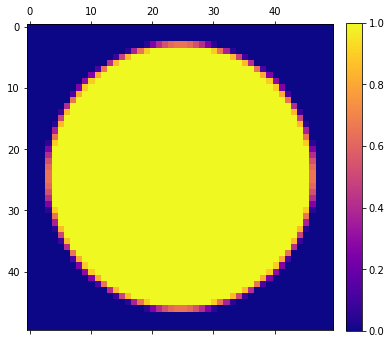

In [3]:
# Simple circular filter with basic anti-aliasing.
circle = np.array(np.clip((0.825 - (x*x + y*y)) * 12.0, 0.0, 1.0), dtype='float64')

# Show the shape.
plt.rcParams["figure.figsize"] = (6, 6)
plt.matshow(circle, cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

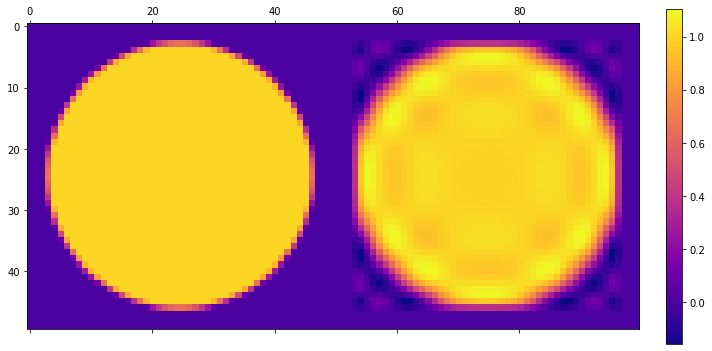

In [4]:
# Returns SVD-based low rank approximation of the matrix m.
def low_rank_approx(m, rank = 1):
  U,E,V = np.linalg.svd(m)
  mn = np.zeros_like(m)
  vs = []
  for i in range(rank):
    mn += np.outer(U[:,i] * np.sqrt(E[i]), V[i,:] * np.sqrt(E[i]))
    # We collect the U and V vectors and distribute the singular value uniformly in both of them.
    vs.append((U[:,i] * np.sqrt(E[i]), V[i,:] * np.sqrt(E[i])))
  return mn, vs

# Show an example low rank approximation.
plt.rcParams["figure.figsize"] = (6, 6)
plt.matshow(np.hstack((circle, low_rank_approx(circle, 4)[0])), cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [0]:
REF_SHAPE = circle
RANK = 4
_, vs = low_rank_approx(REF_SHAPE, RANK)

# We just sum the outer tensor products.
# vs is a list of tuples - pairs of separable horizontal and vertical filters.
def model(vs):
  dst = jnp.zeros((FILTER_SIZE, FILTER_SIZE))
  for separable_pass in vs:
    dst += jnp.outer(separable_pass[0], separable_pass[1])
  return dst

# Our loss function. 
def loss(vs, l2_weight = 1.0, non_negativity_weight = 2.0, keep_zeros_weight = 0.1):
  mdld = model(vs)
  l2_term = l2_weight * jnp.mean(jnp.square(mdld - REF_SHAPE))
  non_negative_term = non_negativity_weight * jnp.mean(-jnp.minimum(mdld, 0.0))
  keep_zeros_term = keep_zeros_weight * np.mean((REF_SHAPE == 0.0) * jnp.abs(mdld))
  return l2_term + non_negative_term + keep_zeros_term 

# We perform a single iteration of gradient descent. Jit it for way better performance.
@jax.jit
def update_parameters_step(vs, learning_rate = 0.1, l2_weight = 1.0, non_negativity_weight = 2.0, keep_zeros_weight = 0.1):
  grad_loss = jax.grad(loss)
  grads = grad_loss(vs, l2_weight, non_negativity_weight, keep_zeros_weight)
  return [(param[0] - learning_rate * grad[0], param[1] - learning_rate * grad[1]) for param, grad in zip(vs, grads)]

# Our whole optimization loop.
def optimize_loop(vs, l2_weight = 1.0, non_negativity_weight = 2.0, keep_zeros_weight = 0.1, print_loss = False):
  NUM_STEPS = 5000
  for n in range(NUM_STEPS):
    vs = update_parameters_step(vs, l2_weight=l2_weight, non_negativity_weight=non_negativity_weight, keep_zeros_weight=keep_zeros_weight)
    if print_loss and n % 1000 == 0:
      print(loss(vs))
  return vs

In [6]:
optimized_filters = []
for non_negativity in (0.0, 0.5, 1.5):
  for keep_zeros in (0.0, 0.3, 0.8):
    _, vs = low_rank_approx(REF_SHAPE, RANK)
    vs = optimize_loop(vs, non_negativity_weight=non_negativity, keep_zeros_weight=keep_zeros)
    optimized_filters.append(model(vs))

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


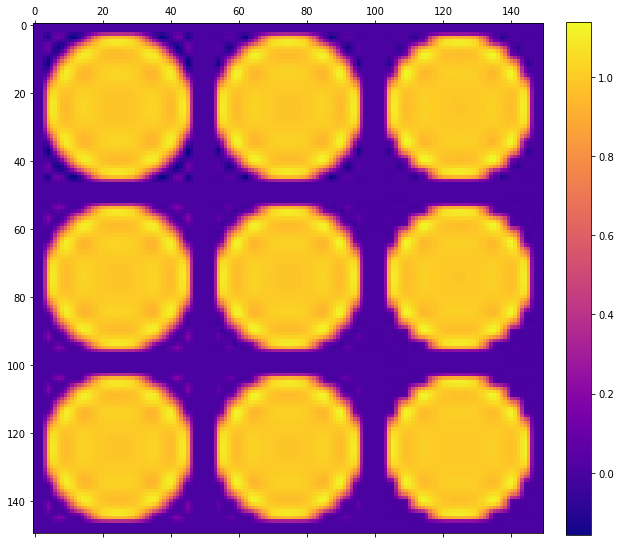

In [7]:
def stack_results(a, function):
  a1 = np.hstack((function(a[0]),function(a[1]),function(a[2])))
  a2 = np.hstack((function(a[3]),function(a[4]),function(a[5])))
  a3 = np.hstack((function(a[6]),function(a[7]),function(a[8])))
  return np.vstack((a1, a2, a3))
plt.rcParams["figure.figsize"] = (10, 10)
plt.matshow(stack_results(optimized_filters, lambda x: x), cmap='plasma')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [0]:
test_img = cv2.imread('kodim14.png')[:,:,(2,1,0)] / 255.0
def fake_tonemap(x):
  return np.power(np.clip(x, 0, 1), 1.0/8.0)
def fake_inv_tonemap(x):
  return np.power(np.clip(x, 0, 1), 8.0)
def filter(img, x):
  res = np.zeros_like(img)
  for c in range(3):
    # Note that we normalize the filter to preserve the image brightness.
    res[:,:,c] = fake_tonemap(scipy.ndimage.convolve(fake_inv_tonemap(img[:,:,c]), x/np.sum(x)))
  return res

res = stack_results(optimized_filters, lambda x: filter(test_img, x))

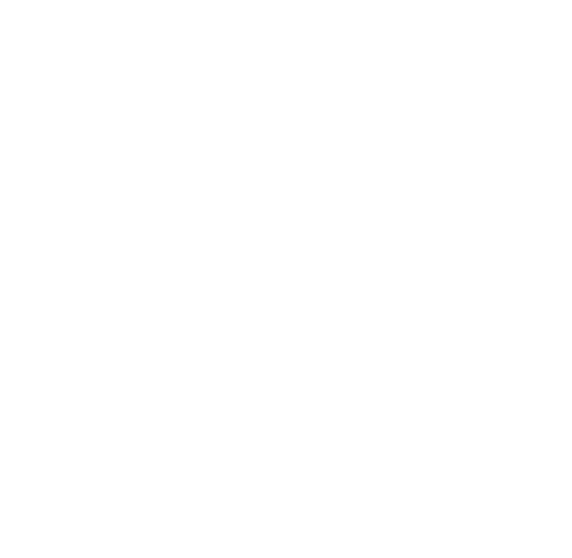

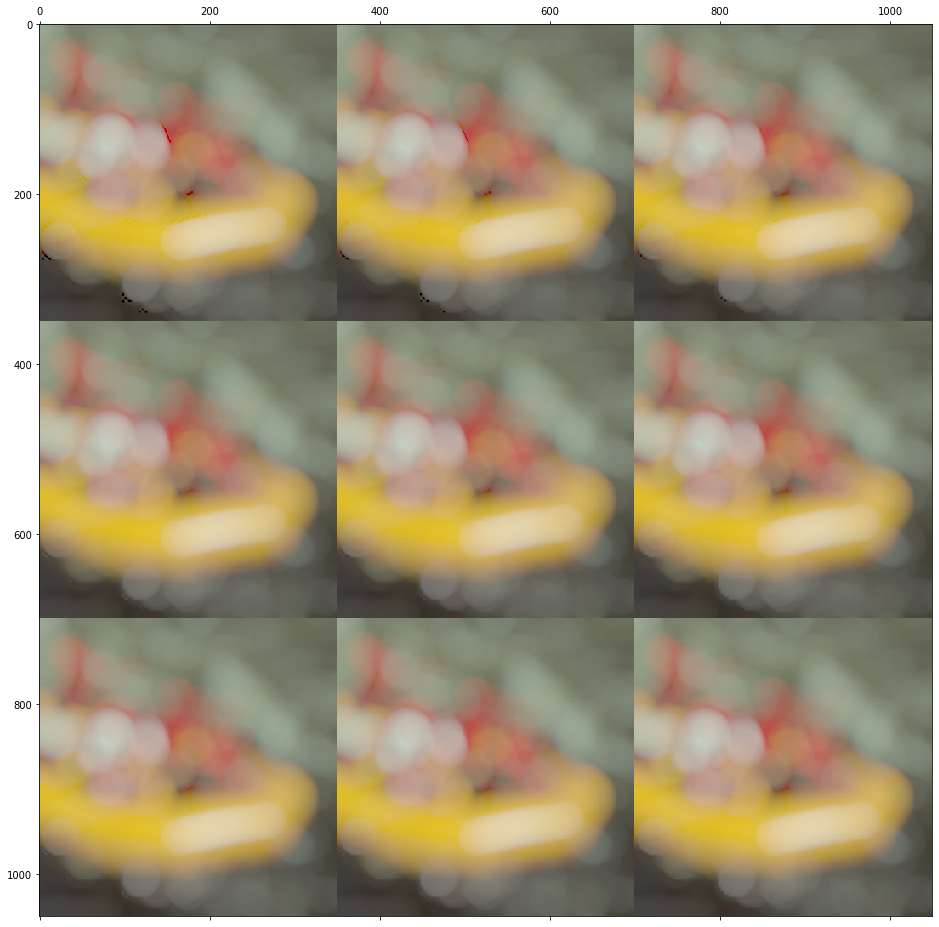

In [9]:
plt.axis("off")
plt.rcParams["figure.figsize"] = (30, 30)
plt.matshow(res)
plt.show()

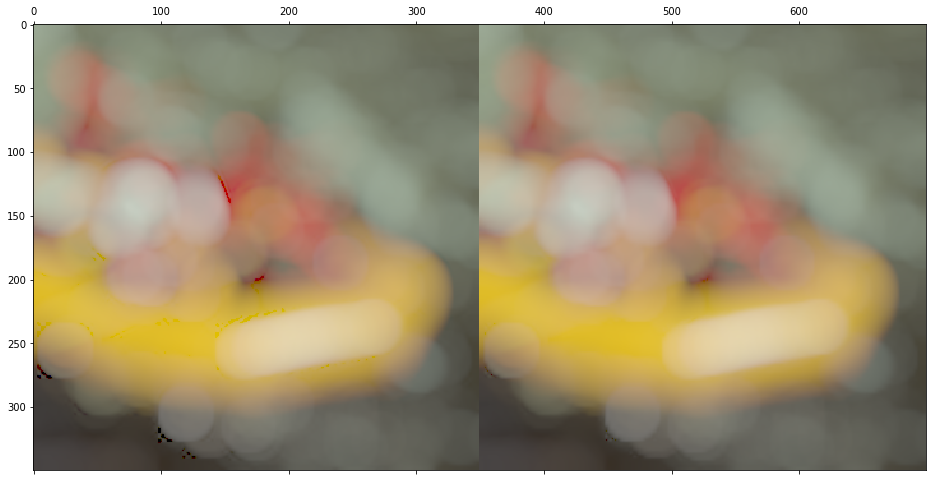

In [10]:
plt.matshow(np.hstack((filter(test_img, optimized_filters[0]),filter(test_img, optimized_filters[4]))))

<a list of 9 text.Text objects>

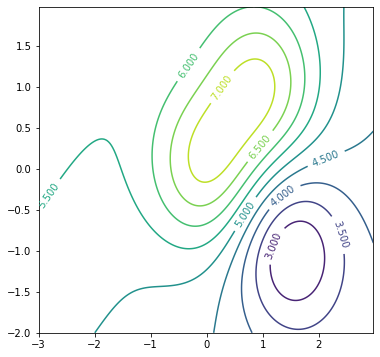

In [12]:
# Non convex example
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z3 = np.exp(-(X - 1.5)**2 - (Y + 1)**2)
Z = (Z1 + Z2 - Z3 -0.1*X + 0.1*Y) * 2 + 5.0
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, 10)
ax.clabel(CS, inline=1, fontsize=10)